# **Lung Cancer Classification using Computerized Tomography (CT) Data**  
<div style="text-align: center;">
    <img src="portrait.png" alt="CT Lung Image" style="width:100%; height:50%;">
</div>


## **Abstract**
Lung cancer remains one of the leading causes of cancer-related deaths worldwide, primarily due to late-stage diagnoses. Early detection through imaging technologies like Computerized Tomography (CT) scans has been shown to significantly improve patient outcomes. The objective of this notebook is to develop an efficient classification system to predict the condition of patients by analyzing CT scan data, thereby facilitating early detection of lung cancer.

To achieve this, we utilize a combination of traditional Machine Learning techniques alongside advanced Deep Learning algorithms, with a particular focus on Convolutional Neural Networks (CNNs) due to their effectiveness in image analysis. Furthermore, Computer Vision techniques are applied to optimize image pre-processing and feature extraction, ensuring the robustness and accuracy of the model.


## **Introduction**

### Context of the Problem
Lung cancer is one of the deadliest types of cancer, responsible for millions of deaths globally each year. The prognosis for patients with lung cancer greatly depends on the stage at which the disease is detected. Unfortunately, most lung cancer cases are diagnosed at an advanced stage, limiting treatment options and reducing survival rates. Early detection is crucial in improving patient outcomes, as it allows for timely interventions and a broader range of treatment strategies.

Computerized Tomography (CT) scans play a key role in lung cancer diagnosis. CT imaging provides detailed, cross-sectional views of the lungs, allowing physicians to detect abnormalities such as tumors, nodules, or tissue damage. However, the manual analysis of CT images is time-consuming, subject to human error, and dependent on the expertise of the radiologist. Therefore, automating the classification of lung cancer from CT images using Machine Learning (ML) and Deep Learning (DL) offers significant potential to enhance diagnostic accuracy and efficiency.

### Objective of the Work
This notebook aims to build a robust classification model for detecting lung cancer based on CT scan images. By leveraging techniques from both Machine Learning and Deep Learning, particularly statistical models, we aim to automatically classify CT images as cancerous or non-cancerous. The primary goal is to provide an automated, reliable, and scalable solution to aid in the early detection of lung cancer, thereby improving patient prognosis.

### Structure of the Work
This notebook is structured as follows:

- Data Exploration and Preprocessing: We begin by exploring the dataset, including a detailed visualization of the CT images to gain insights into the structure and distribution of the data. The preprocessing phase involves essential Computer Vision steps such as image normalization to standardize pixel intensity values and segmentation to isolate regions of interest (e.g., lung nodules), which are critical for enhancing model performance and improving feature extraction. Additionally, we apply semi-supervised learning techniques to refine the dataset, leveraging unlabeled/uncertain data to improve the overall quality and representativeness of the training set.

- Model Development: Next, we build and train various classification models(traditional ML algorithms) comparing their performance across different metrics.

- Evaluation and Results: The performance of the models will be assessed using key metrics such as accuracy, precision, recall, and the AUC-ROC curve. Once the best-performing model is identified, we apply hyperparameter tuning techniques to further optimize its performance and maximize its predictive effectiveness.

- Discussion and Future Work: Finally, we will discuss the results, highlighting the strengths and limitations of our approach, and propose potential improvements or future research directions for lung cancer classification using medical imaging.

## **Exploratory Data Analysis(EDA)**
To enhance data visualization and exploration, a custom classes will be developed. This class will implement methods for nodule visualization, querying, and radiomics extraction, which will facilitate subsequent analysis and research.

*Disclaimer: Certain functions in the PyLIDC library, which rely on external packages such as **Numpy, Scikit-learn, and Matplotlib**, among others, have been slightly modified to address compatibility issues arising from deprecated versions.*


In [13]:
import pylidc as pl
import numpy as np
import matplotlib.pyplot as plt
from radiomics.featureextractor import *
import medpy
from sklearn.cluster import KMeans
from scipy.ndimage import zoom
import SimpleITK as sitk


In [14]:
# Base class for managing LIDC queries and scans
class LIDCBase:
    def __init__(self, pid):
        self.pid = pid
        self.scan = None

    def query_scan(self):
        """Query and return the scan for the given patient ID."""
        self.scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == self.pid).first()
        if not self.scan:
            raise ValueError(f"No scan found for patient ID {self.pid}")
        return self.scan


# Derived class PyLIDC with additional functionalities
class PyLIDC(LIDCBase):
    
    def __init__(self, pid):
        super().__init__(pid)

    def get_nodules(self):
        """Return the list of nodules for the queried scan."""
        if not self.scan:
            self.query_scan()  # Ensure the scan is queried
        return self.scan.cluster_annotations()  # This will cluster annotations as nodules via euclidian distance

    def get_nodule_count(self):
        """Return the number of nodules in the scan."""
        nodules = self.get_nodules()
        return len(nodules)
    
    def resample_image_to_match(self,image, mask):

        """
        Resamples the mask to match the dimensions and resolution of the image.
        
        Parameters:
        image: The original SimpleITK image (scan)
        mask: The SimpleITK mask to be resampled
        
        Returns:
        The resampled mask as a SimpleITK image.
        """
        # Obtener la información del espacio de la imagen original
        original_spacing = image.GetSpacing()
        original_size = image.GetSize()

        # Configurar el resampleador
        resample = sitk.ResampleImageFilter()
        resample.SetOutputSpacing(original_spacing)
        resample.SetSize(original_size)
        resample.SetOutputDirection(image.GetDirection())
        resample.SetOutputOrigin(image.GetOrigin())
        resample.SetTransform(sitk.Transform())
        resample.SetInterpolator(sitk.sitkNearestNeighbor)  # Nearest neighbor para máscaras

        # Resamplear la máscara
        resampled_mask = resample.Execute(mask)
        
        return resampled_mask

    def extract_radiomics(self, nodule_idx=0):
        """
        Extract radiomic features for a specific nodule.
        
        Parameters:
        nodule_idx: Index of the nodule to extract features from.
        
        Returns:
        Dictionary of radiomic features.
        """

        
        
        
        if not self.scan:
            self.query_scan()
        
        nodules = self.get_nodules()
        if nodule_idx >= len(nodules):
            raise IndexError(f"Nodule index {nodule_idx} is out of range. Total nodules: {len(nodules)}")

        nodule = nodules[nodule_idx]

        #Obtain a list of all the annotations of the nodule, 
        annotations = nodule
        
        # # Initialize an empty mask as they all have the same dimensions as the annotations from the first radilogist
        # mask_shape = annotations[0].boolean_mask(pad=[(1,1), (1,1), (1,1)]).shape
        # combined_mask = np.zeros(mask_shape)
        
        # for annotation in annotations: 
        #     current_mask = annotation.boolean_mask(pad=[(1,1), (1,1), (1,1)])

        #     if current_mask.shape!=mask_shape:
        #         zoom_factors=[ref_dim / float(curr_dim) for ref_dim, curr_dim in zip(mask_shape, current_mask.shape)]
        #         current_mask=zoom(current_mask,zoom_factors,order=1)
        #     combined_mask += current_mask

        # # Obtain the average of the mask
        # combined_mask=combined_mask/len(annotations)

        # #Otra opción es utilizar un umbral. Ejemplo : SI más de la mitad de los radiólogos están de acuerdo en un píxel se toma como parte del nódulo
        # # consesus_mask= (combined_mask>0.5).astype(np.unit8)
        
        # scan_array = self.scan.to_volume()  # Convert the scan to a volume array
        # sitk_image = sitk.GetImageFromArray(scan_array)  # Convertimos el volumen a SimpleITK
        # sitk_mask = sitk.GetImageFromArray(combined_mask)  # Convertimos la máscara a SimpleITK
        # sitk_mask_resampled = self.resample_image_to_match(sitk_image, sitk_mask)

        # Encontrar el bounding box más grande que contenga todas las máscaras
        min_x, min_y, min_z = np.inf, np.inf, np.inf
        max_x, max_y, max_z = -np.inf, -np.inf, -np.inf
        
        for annotation in annotations:
            mask = annotation.boolean_mask(pad=[(1,1), (1,1), (1,1)])
            x, y, z = mask.shape
            
            # Determinar el bounding box
            min_x, min_y, min_z = min(min_x, x), min(min_y, y), min(min_z, z)
            max_x, max_y, max_z = max(max_x, x), max(max_y, y), max(max_z, z)
        
        # Crear una máscara combinada con el tamaño del bounding box
        combined_mask = np.zeros((max_x, max_y, max_z))
        
        # Redimensionar todas las máscaras al tamaño del bounding box y sumarlas
        for annotation in annotations:
            current_mask = annotation.boolean_mask(pad=[(1,1), (1,1), (1,1)])
            zoom_factors = [max_dim / float(curr_dim) for max_dim, curr_dim in zip(combined_mask.shape, current_mask.shape)]
            current_mask = zoom(current_mask, zoom_factors, order=1)  # Redimensionado
            
            combined_mask += current_mask  # Sumar la máscara redimensionada
        
        # Tomar el promedio de las máscaras (o convertir a binario si se requiere un umbral)
        combined_mask = combined_mask / len(annotations)
        # consensus_mask = (combined_mask >= 0.5).astype(np.uint8)  

        # Convertir el scan a un volumen para poder extraer radiomics
        scan_array = self.scan.to_volume()

        # Convertir a objetos SimpleITK
        image_sitk = sitk.GetImageFromArray(scan_array)
        mask_sitk = sitk.GetImageFromArray(combined_mask)
        sitk_mask_resampled = self.resample_image_to_match(image_sitk, mask_sitk)

        # Extracción de características radiómicas utilizando pyradiomics
        extractor = RadiomicsFeatureExtractor()
        features = extractor.execute(image_sitk, sitk_mask_resampled)


        return features

    def summary(self):
        """Prints a summary of the scan, including patient ID, number of nodules, and scan dimensions."""
        if not self.scan:
            self.query_scan()

        print(f"Patient ID: {self.pid}")
        print(f"Number of nodules: {self.get_nodule_count()}")
        print(f"Scan dimensions (voxels): {self.scan.to_volume().shape}")
        print(f"Pixel spacing (mm): {self.scan.pixel_spacing}")
        print(f"Slice thickness (mm): {self.scan.slice_thickness}")
        

In [15]:
l = PyLIDC('LIDC-IDRI-0001')
l.get_nodule_count()
l.summary()


Patient ID: LIDC-IDRI-0001
Number of nodules: 1
Loading dicom files ... This may take a moment.
Scan dimensions (voxels): (512, 512, 133)
Pixel spacing (mm): 0.703125
Slice thickness (mm): 2.5


In [16]:
l = PyLIDC('LIDC-IDRI-0078')
nodules = l.get_nodules()
ann = nodules[1][0]
mask = ann.boolean_mask()
print(mask.shape, mask.dtype)
# => (34, 27, 6), dtype('bool')

# VOLUME OF THE NODULE WITH BBOX
bbox = ann.bbox()
print(bbox)
# => (slice(151, 185, None), slice(349, 376, None), slice(44, 50, None))

vol = ann.scan.to_volume()
print(vol[bbox])

(34, 27, 6) bool
(slice(151, 185, None), slice(349, 376, None), slice(44, 50, None))
Loading dicom files ... This may take a moment.
[[[-857 -831 -806 -828 -830 -830]
  [-866 -855 -834 -830 -826 -840]
  [-859 -890 -876 -844 -810 -841]
  ...
  [-837 -842 -672 -180  286  397]
  [-821 -783 -522   11  413  457]
  [-771 -633 -274  212  490  434]]

 [[-854 -834 -820 -809 -760 -807]
  [-855 -852 -843 -823 -744 -823]
  [-858 -870 -874 -851 -732 -836]
  ...
  [-858 -853 -768 -402   98  229]
  [-848 -828 -705 -252  269  409]
  [-831 -776 -560  -54  412  501]]

 [[-858 -862 -854 -795 -706 -805]
  [-852 -863 -858 -822 -714 -827]
  [-846 -854 -865 -855 -743 -852]
  ...
  [-858 -866 -805 -505  -25   87]
  [-837 -858 -797 -421   71  235]
  [-847 -832 -740 -281  223  424]]

 ...

 [[-749 -652 -732 -728 -663 -817]
  [-572 -495 -696 -668 -546 -803]
  [-441 -370 -681 -628 -443 -777]
  ...
  [-888 -846 -844 -823 -832 -856]
  [-875 -859 -833 -822 -792 -841]
  [-857 -857 -841 -818 -723 -827]]

 [[-773 -658 

In [17]:

nods = l.get_nodules()
anns = nods[1]
anns

[Annotation(id=1,scan_id=1),
 Annotation(id=5,scan_id=1),
 Annotation(id=9,scan_id=1),
 Annotation(id=12,scan_id=1)]

In [18]:

l_n1= l.extract_radiomics(1)

Loading dicom files ... This may take a moment.


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [19]:
nodules[0]

[Annotation(id=2,scan_id=1),
 Annotation(id=6,scan_id=1),
 Annotation(id=10,scan_id=1),
 Annotation(id=13,scan_id=1)]

Loading dicom files ... This may take a moment.


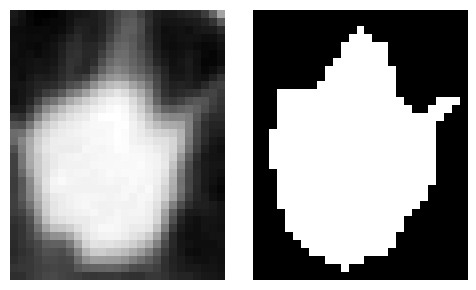

In [20]:
import pylidc as pl
import matplotlib.pyplot as plt
from pylidc.utils import consensus

ann = pl.query(pl.Annotation).first()
vol = ann.scan.to_volume()

padding = [(30,10), (10,25), (0,0)]

mask = ann.boolean_mask()
bbox = ann.bbox()

fig,ax = plt.subplots(1,2,figsize=(5,3))

ax[0].imshow(vol[bbox][:,:,2], cmap=plt.cm.gray)
ax[0].axis('off')

ax[1].imshow(mask[:,:,2], cmap=plt.cm.gray)
ax[1].axis('off')

plt.tight_layout()
#plt.savefig("../images/mask_bbox.png", bbox_inches="tight")
plt.show()

Loading dicom files ... This may take a moment.


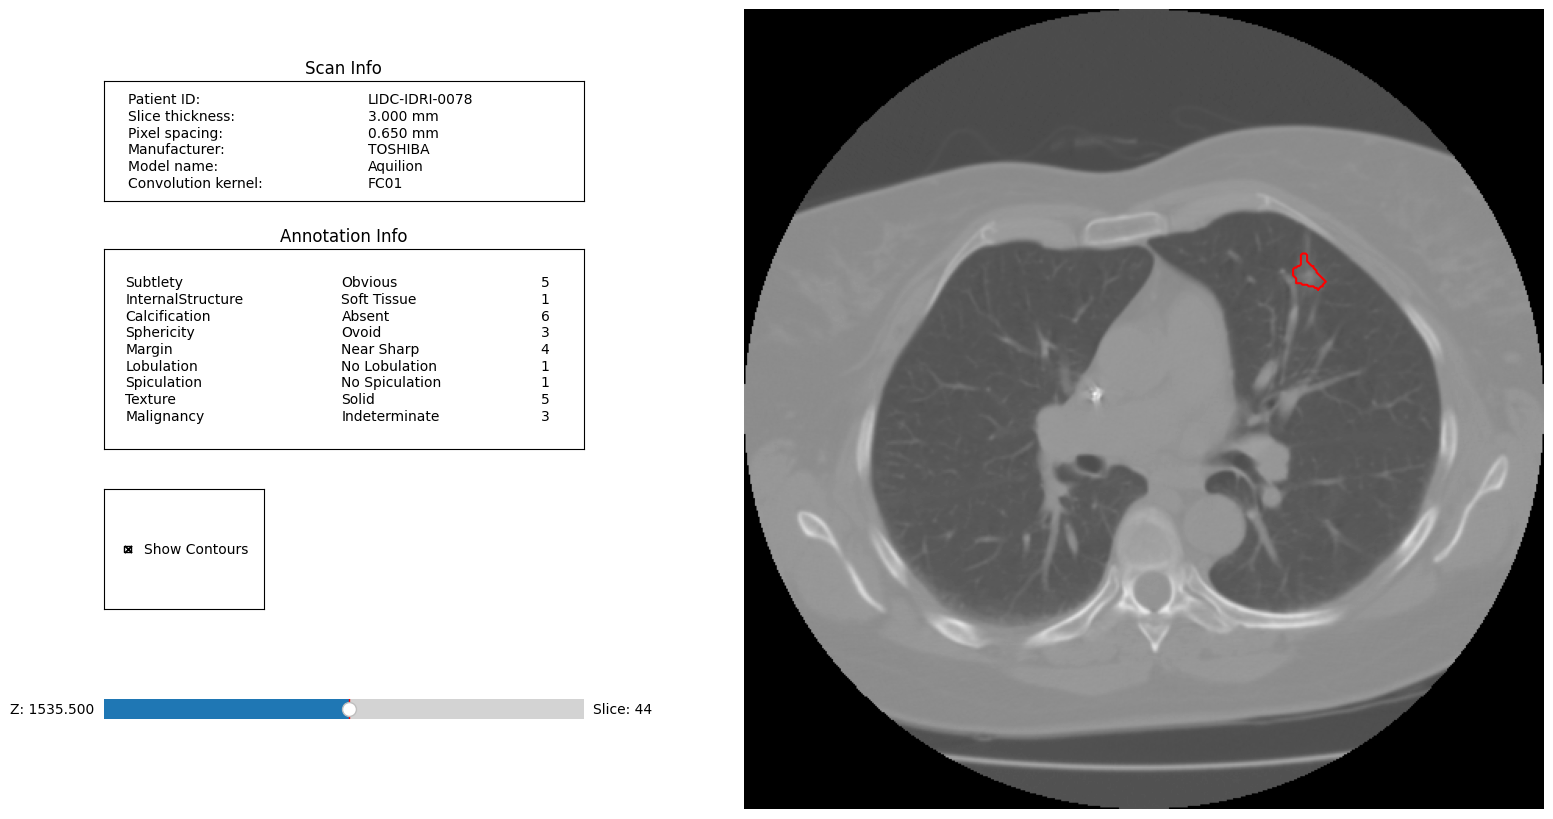

In [21]:
ann.visualize_in_scan()

intento de sacar mascara

In [22]:
from pathlib import Path  # Asegúrate de importar Path
from statistics import  median_high
from utils import  segment_lung
import seaborn as sns

def calculate_malignancy(nodule):
        # Calculate the malignancy of a nodule with the annotations made by 4 doctors. Return median high of the annotated cancer, True or False label for cancer
        # if median high is above 3, we return a label True for cancer
        # if it is below 3, we return a label False for non-cancer
        # if it is 3, we return ambiguous, for future semi-supervised learning processing.
        list_of_malignancy =[]
        for annotation in nodule:
            list_of_malignancy.append(annotation.malignancy)

        malignancy = median_high(list_of_malignancy)
        if  malignancy > 3:
            return malignancy,True
        elif malignancy < 3:
            return malignancy, False
        else:
            return malignancy, 'Ambiguous'

pid = "LIDC-IDRI-0001" #LIDC-IDRI-0001~
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id ==pid).first()
nodules_annotation = scan.cluster_annotations()
vol = scan.to_volume()
print("Patient ID: {} Dicom Shape: {} Number of Annotated Nodules: {}".format(pid,vol.shape,len(nodules_annotation)))

# This is to name each image and mask
prefix = [str(x).zfill(3) for x in range(1000)]

IMAGE_DIR = Path("data/image")
MASK_DIR = Path("data/mask")

patient_image_dir = IMAGE_DIR / pid
patient_mask_dir = MASK_DIR / pid
Path(patient_image_dir).mkdir(parents=True, exist_ok=True)
Path(patient_mask_dir).mkdir(parents=True, exist_ok=True)

if len(nodules_annotation) > 0:
    # Patients with nodules
    for nodule_idx, nodule in enumerate(nodules_annotation):
    # Call nodule images. Each Patient will have at maximum 4 annotations as there are only 4 doctors
    # This current for loop iterates over total number of nodules in a single patient
        mask, cbbox, masks = consensus(nodule,0.5,512)
        lung_np_array = vol[cbbox]
   
        # We calculate the malignancy information
        malignancy, cancer_label = calculate_malignancy(nodule)

        for nodule_slice in range(mask.shape[2]):
            # This second for loop iterates over each single nodule.
            # There are some mask sizes that are too small. These may hinder training.
            if np.sum(mask[:,:,nodule_slice]) <= 0.5:
                continue
            # Segment Lung part only
            lung_segmented_np_array = segment_lung(lung_np_array[:,:,nodule_slice])
            # I am not sure why but some values are stored as -0. <- this may result in datatype error in pytorch training # Not sure
            lung_segmented_np_array[lung_segmented_np_array==-0] =0
            # This itereates through the slices of a single nodule
            # Naming of each file: NI= Nodule Image, MA= Mask Original
            nodule_name = "{}_NI{}_slice{}".format(pid[-4:],prefix[nodule_idx],prefix[nodule_slice])
            mask_name = "{}_MA{}_slice{}".format(pid[-4:],prefix[nodule_idx],prefix[nodule_slice])
            meta_list = [pid[-4:],nodule_idx,prefix[nodule_slice],nodule_name,mask_name,malignancy,cancer_label,False]

            np.save(patient_image_dir / nodule_name,lung_segmented_np_array)
            np.save(patient_mask_dir / mask_name,mask[:,:,nodule_slice])
        

Loading dicom files ... This may take a moment.
Patient ID: LIDC-IDRI-0001 Dicom Shape: (512, 512, 133) Number of Annotated Nodules: 1


c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\Lab IA and CD\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\Lab IA and CD\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\OneDrive - Universidad de Oviedo\Escritorio\UNI\3ºAÑO\Lab IA and CD\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, defau

Forma del arreglo: (512, 512)


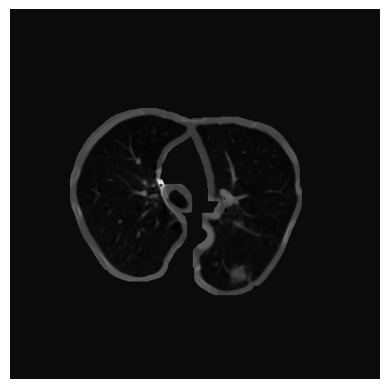

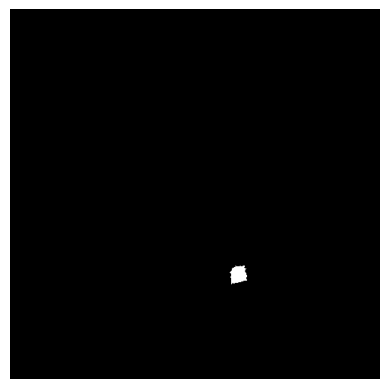

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Cargar el archivo .npy
file_path = r"data\image\LIDC-IDRI-0001\0001_NI000_slice093.npy" # Reemplaza con la ruta a tu archivo
data = np.load(file_path)

# Cargar el archivo .npy
file_path2 = r"data\mask\LIDC-IDRI-0001\0001_MA000_slice093.npy" # Reemplaza con la ruta a tu archivo
data2 = np.load(file_path2)

# Imprimir la forma del arreglo
print("Forma del arreglo:", data.shape)

# Visualizar datos (si es un arreglo 2D o 3D)
if data.ndim == 2:  # Si el arreglo es 2D
    plt.imshow(data, cmap='gray')  # Muestra la imagen en escala de grises
    plt.axis('off')  # Oculta los ejes
    plt.show()

    plt.imshow(data2, cmap='gray')  # Muestra la imagen en escala de grises
    plt.axis('off')  # Oculta los ejes
    plt.show()
elif data.ndim == 3:  # Si el arreglo es 3D
    # Suponiendo que queremos mostrar el primer "slice" del arreglo 3D
    plt.imshow(data[:, :, 0], cmap='gray')  # Muestra el primer slice en escala de grises
    plt.axis('off')  # Oculta los ejes
    plt.show()
else:
    print("El arreglo no es 2D ni 3D. Forma:", data.shape)


In [24]:
data2

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [25]:
import numpy as np
import SimpleITK as sitk



def numpy_to_sitk(np_array):
    """
    Convierte un arreglo NumPy en un objeto SimpleITK.Image.
    """
    return sitk.GetImageFromArray(np_array)

def extract_radiomics(scan_array, mask_array):
    """
    Extract radiomic features for a specific nodule using pyradiomics.
    Returns:
    Dictionary of radiomic features.
    """
    # Convertir los arrays NumPy a objetos SimpleITK
    scan_sitk = numpy_to_sitk(scan_array)

    # Convertir la máscara booleana (True/False) a una máscara entera (1/0)
    mask_array_int = mask_array.astype(np.uint8)
    mask_sitk = numpy_to_sitk(mask_array_int)

    # Configurar el extractor de radiomics
    extractor = RadiomicsFeatureExtractor()

    # Extraer las características
    features = extractor.execute(scan_sitk, mask_sitk)

    return features

# Cargar el archivo .npy del escaneo
file_path = r"data\image\LIDC-IDRI-0001\0001_NI000_slice093.npy"
data = np.load(file_path)

# Cargar el archivo .npy de la máscara (booleana)
file_path2 = r"data\mask\LIDC-IDRI-0001\0001_MA000_slice093.npy"
data2 = np.load(file_path2)

# Extraer características radiómicas
f = extract_radiomics(data, data2)


Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


INICIO

In [26]:
f.keys()

odict_keys(['diagnostics_Versions_PyRadiomics', 'diagnostics_Versions_Numpy', 'diagnostics_Versions_SimpleITK', 'diagnostics_Versions_PyWavelet', 'diagnostics_Versions_Python', 'diagnostics_Configuration_Settings', 'diagnostics_Configuration_EnabledImageTypes', 'diagnostics_Image-original_Hash', 'diagnostics_Image-original_Dimensionality', 'diagnostics_Image-original_Spacing', 'diagnostics_Image-original_Size', 'diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum', 'diagnostics_Image-original_Maximum', 'diagnostics_Mask-original_Hash', 'diagnostics_Mask-original_Spacing', 'diagnostics_Mask-original_Size', 'diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_VoxelNum', 'diagnostics_Mask-original_VolumeNum', 'diagnostics_Mask-original_CenterOfMassIndex', 'diagnostics_Mask-original_CenterOfMass', 'original_firstorder_10Percentile', 'original_firstorder_90Percentile', 'original_firstorder_Energy', 'original_firstorder_Entropy', 'original_firstorder_Interqua

In [27]:
f

OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.1.0'),
             ('diagnostics_Versions_Numpy', '1.24.4'),
             ('diagnostics_Versions_SimpleITK', '2.4.0'),
             ('diagnostics_Versions_PyWavelet', '1.4.1'),
             ('diagnostics_Versions_Python', '3.8.10'),
             ('diagnostics_Configuration_Settings',
              {'minimumROIDimensions': 2,
               'minimumROISize': None,
               'normalize': False,
               'normalizeScale': 1,
               'removeOutliers': None,
               'resampledPixelSpacing': None,
               'interpolator': 'sitkBSpline',
               'preCrop': False,
               'padDistance': 5,
               'distances': [1],
               'force2D': False,
               'force2Ddimension': 0,
               'resegmentRange': None,
               'label': 1,
               'additionalInfo': True}),
             ('diagnostics_Configuration_EnabledImageTypes', {'Original': {}}),
             ('diagn

In [28]:
import pylidc as pl
import os

DICOM_DIR = r"./LIDC-IDRI"
IDRI_list = [f for f in os.listdir(DICOM_DIR) if not f.startswith('.')]
print(f"There are {len(IDRI_list)} patients")

pid = 'LIDC-IDRI-0078'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: './LIDC-IDRI'

In [18]:
a = scan.cluster_annotations()[0][0]

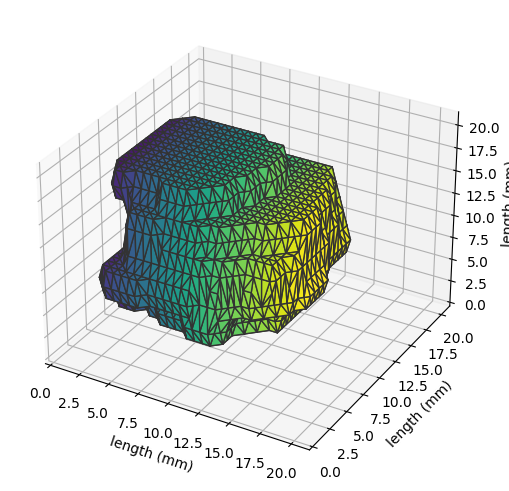

In [19]:
a.visualize_in_3d(cmap='viridis')

In [15]:

for patient in IDRI_list:
    pid = patient  # LIDC-IDRI-0001~
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
    nodules_annotation = scan.cluster_annotations()
    vol = scan.to_volume()
    print("Patient ID: {} Dicom Shape: {} Number of Annotated Nodules: {}".format(pid, vol.shape, len(nodules_annotation)))


Loading dicom files ... This may take a moment.
Patient ID: LIDC-IDRI-0001 Dicom Shape: (512, 512, 133) Number of Annotated Nodules: 1
Loading dicom files ... This may take a moment.
Patient ID: LIDC-IDRI-0002 Dicom Shape: (512, 512, 261) Number of Annotated Nodules: 1
Loading dicom files ... This may take a moment.
Patient ID: LIDC-IDRI-0003 Dicom Shape: (512, 512, 140) Number of Annotated Nodules: 4
Loading dicom files ... This may take a moment.
Patient ID: LIDC-IDRI-0004 Dicom Shape: (512, 512, 241) Number of Annotated Nodules: 1
Loading dicom files ... This may take a moment.
Patient ID: LIDC-IDRI-0005 Dicom Shape: (512, 512, 133) Number of Annotated Nodules: 3
Loading dicom files ... This may take a moment.
Patient ID: LIDC-IDRI-0006 Dicom Shape: (512, 512, 133) Number of Annotated Nodules: 4
Loading dicom files ... This may take a moment.
Patient ID: LIDC-IDRI-0007 Dicom Shape: (512, 512, 145) Number of Annotated Nodules: 2
Loading dicom files ... This may take a moment.
Patient

KeyboardInterrupt: 

In [18]:
for nodule_idx, nodule in enumerate(nodules_annotation):
    print(nodule)
    mask, cbbox, masks = consensus(nodule,0.5,512)
    lung_np_array = vol[cbbox]
    print(lung_np_array)

[Annotation(id=136,scan_id=20)]
[[[-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  ...
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]]

 [[-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  ...
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]]

 [[-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  ...
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]]

 ...

 [[-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  [-2048 -2048 -2048 ... -2048 -2048 -2048]
  ...
  [-2048

Loading dicom files ... This may take a moment.


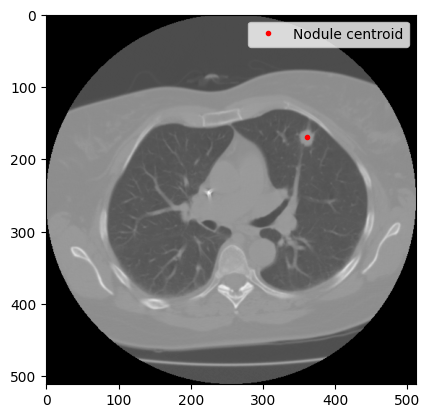

In [2]:
import pylidc as pl
import matplotlib.pyplot as plt

ann = pl.query(pl.Annotation).first()
i,j,k = ann.centroid

vol = ann.scan.to_volume()

plt.imshow(vol[:,:,int(k)], cmap=plt.cm.gray)
plt.plot(j, i, '.r', label="Nodule centroid")
plt.legend()
plt.show()

Scan(id=1,patient_id=LIDC-IDRI-0078) has 4 nodules.
Nodule 1 has 4 annotations.
Nodule 2 has 4 annotations.
Nodule 3 has 1 annotations.
Nodule 4 has 4 annotations.
Loading dicom files ... This may take a moment.
(512, 512, 87)
-702.15, 812.52
Loading dicom files ... This may take a moment.


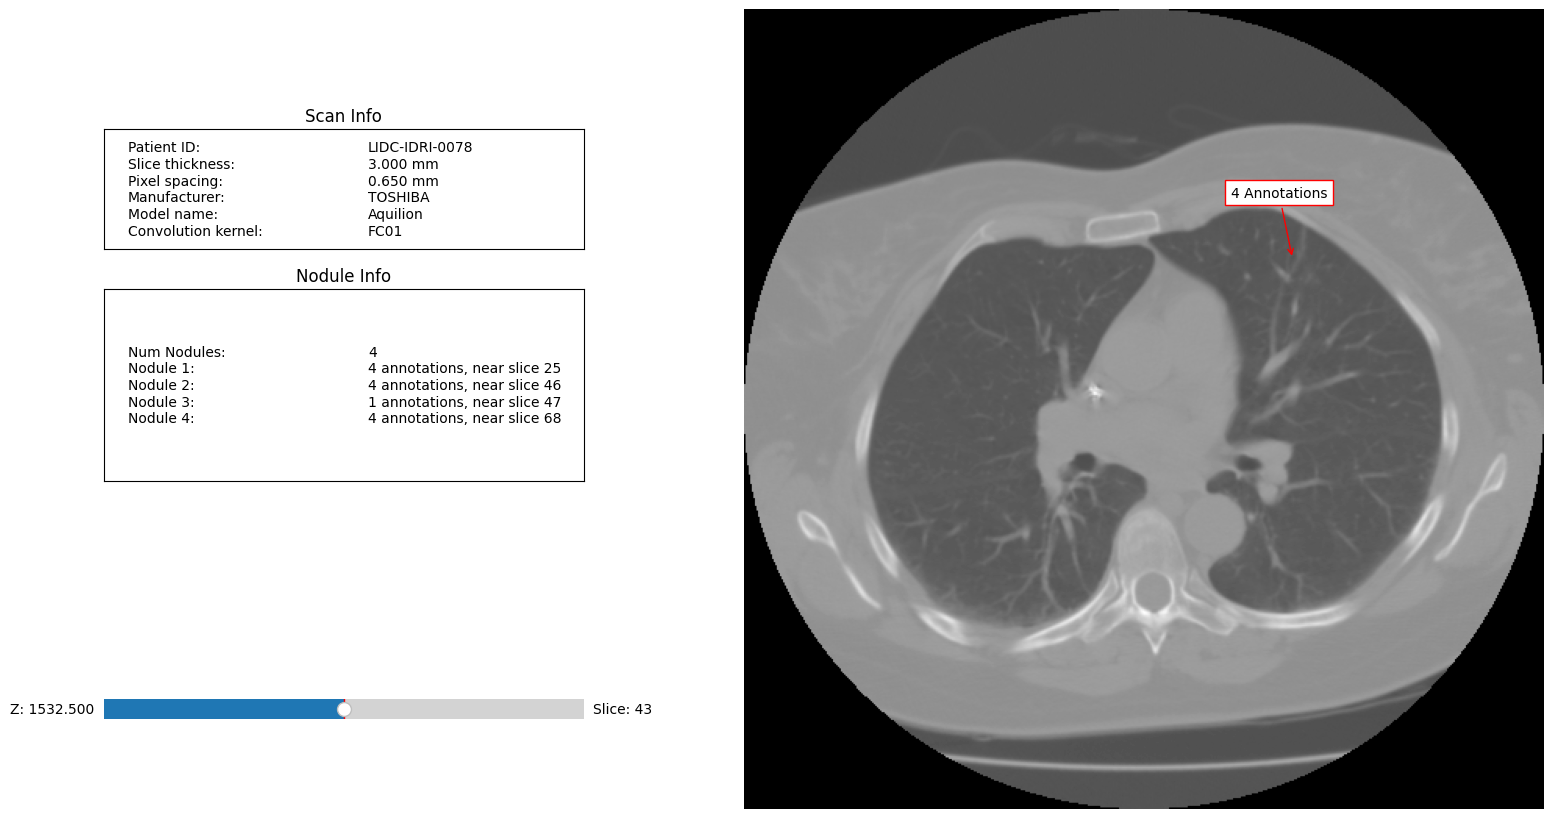

In [13]:
nods = scan.cluster_annotations()

print("%s has %d nodules." % (scan, len(nods)))
# => Scan(id=1,patient_id=LIDC-IDRI-0078) has 4 nodules.

for i,nod in enumerate(nods):
    print("Nodule %d has %d annotations." % (i+1, len(nods[i])))
# => Nodule 1 has 4 annotations.
# => Nodule 2 has 4 annotations.
# => Nodule 3 has 1 annotations.
# => Nodule 4 has 4 annotations.
vol = scan.to_volume()
print(vol.shape)
# => (512, 512, 87)

print("%.2f, %.2f" % (vol.mean(), vol.std()))
# => -702.15, 812.52
scan.visualize(annotation_groups=nods)

In [13]:
import pylidc as pl

# Get the first annotation with spiculation value greater than 3.
ann = pl.query(pl.Annotation)\
        .filter(pl.Annotation.spiculation > 3).first()

print(ann.spiculation)
# => 4

# Each nodule feature has a corresponding property
# to print the semantic value.
print(ann.Spiculation)
# => Medium-High Spiculation

print("%.2f, %.2f, %.2f" % (ann.diameter,
                            ann.surface_area,
                            ann.volume))

4
Near Marked Spiculation


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [2]:
import pylidc as pl
import matplotlib.pyplot as plt

ann = pl.query(pl.Annotation).first()
vol = ann.scan.to_volume()

mask = ann.boolean_mask()
bbox = ann.bbox()

print("Avg HU inside nodule: %.1f" % vol[bbox][mask].mean())
# => Avg HU inside nodule: -280.0

print("Avg HU outside nodule: %.1f" % vol[bbox][~mask].mean())
# => Avg HU outside nodule: -732.2

Loading dicom files ... This may take a moment.
Avg HU inside nodule: -231.2
Avg HU outside nodule: -718.5


In [8]:
import pylidc as pl

ann = pl.query(pl.Annotation).first()

zvals = ann.contour_slice_zvals
kvals = ann.contour_slice_indices
scan_zvals = ann.scan.slice_zvals

for k,z in zip(kvals, zvals):
    # the two z values should the same (up to machine precision)
    print(k, z, scan_zvals[k])

44 1535.5 1535.5
45 1538.5 1538.5
46 1541.5 1541.5
47 1544.5 1544.5
48 1547.5 1547.5
49 1550.5 1550.5


Loading dicom files ... This may take a moment.


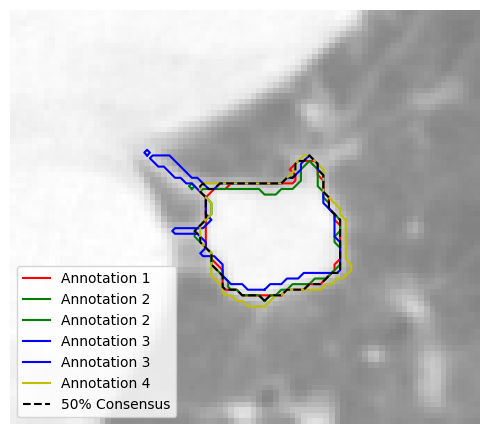

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as manim
from skimage.measure import find_contours

import pylidc as pl
from pylidc.utils import consensus


# Query for a scan, and convert it to an array volume.
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == 'LIDC-IDRI-0078').first()
vol = scan.to_volume()

# Cluster the annotations for the scan, and grab one.
nods = scan.cluster_annotations()
anns = nods[0]

# Perform a consensus consolidation and 50% agreement level.
# We pad the slices to add context for viewing.
cmask,cbbox,masks = consensus(anns, clevel=0.5,
                              pad=[(20,20), (20,20), (0,0)])

# Get the central slice of the computed bounding box.
k = int(0.5*(cbbox[2].stop - cbbox[2].start))

# Set up the plot.
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(vol[cbbox][:,:,k], cmap=plt.cm.gray, alpha=0.5)

# Plot the annotation contours for the kth slice.
colors = ['r', 'g', 'b', 'y']
for j in range(len(masks)):
    for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
        label = "Annotation %d" % (j+1)
        plt.plot(c[:,1], c[:,0], colors[j], label=label)

# Plot the 50% consensus contour for the kth slice.
for c in find_contours(cmask[:,:,k].astype(float), 0.5):
    plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

ax.axis('off')
ax.legend()
plt.tight_layout()
#plt.savefig("../images/consensus.png", bbox_inches="tight")
plt.show()

In [1]:
import pylidc as pl
import matplotlib.pyplot as plt

import numpy as np

# Inicializamos una lista para almacenar las malignidades de los nódulos
malignidades = []

# Consulta a la base de datos LIDC-IDRI para obtener todos los escaneos
scans = pl.query(pl.Scan).all()

# Recorremos cada escaneo
for scan in scans:
    # Obtenemos los nódulos de cada escaneo
    nodules = scan.cluster_annotations()
    print(scan.id)
    
    # Para cada nódulo, recorremos las anotaciones
    for nodule in nodules:
        # Para cada anotación de un nódulo, extraemos la malignidad
        for annotation in nodule:
            malignidades.append(annotation.malignancy)

# Convertimos las malignidades en un array de numpy
malignidades = np.array(malignidades)




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
1

NameError: name 'sns' is not defined

C:\Users\Alejandro\AppData\Local\Temp\ipykernel_19492\2292832535.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=malignidades, palette='Blues')


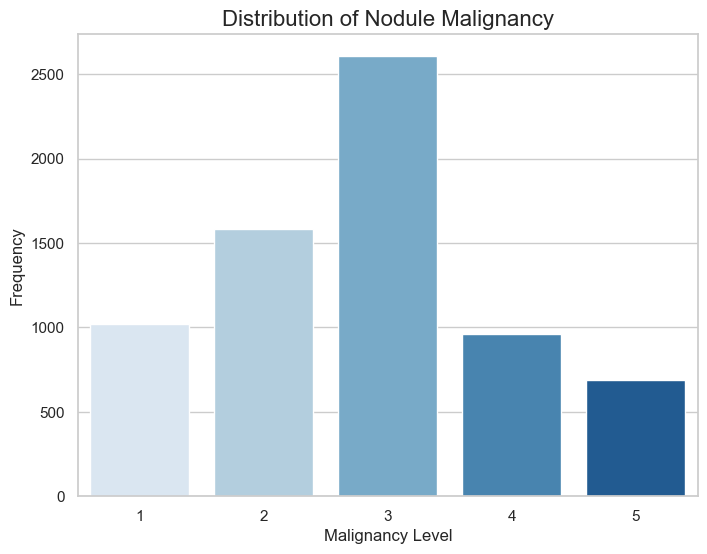

In [9]:
# Set the style of the plot
sns.set(style="whitegrid")

# Create the bar plot for the different malignancy categories (1-5)
plt.figure(figsize=(8, 6))
sns.countplot(x=malignidades, palette='Blues')

# Titles and labels
plt.title('Distribution of Nodule Malignancy', fontsize=16)
plt.xlabel('Malignancy Level', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Display the plot
plt.show()
